In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
from sklearn.preprocessing import PolynomialFeatures


In [3]:
def train_val_test(data, splits=[0.7,0.1,0.2],seed=42):
    '''
    
    Inputs Args: 
    
    data : entire labelled data available
    splits : [train_size, val_size, test_size] # fractions
    
    '''
    
    
    data_patients = data.patient_id.unique()
    
    np.random.seed(seed)
    np.random.shuffle(data_patients) # shuffle patients
    
    splits = [int(i * len(data_patients)) for i in splits]
    train_size, val_size, test_size = splits
    
    train_patients = data_patients[:train_size]
    val_patients   = data_patients[train_size : train_size + val_size]
    test_patients = data_patients[train_size + val_size : ] # we not using test_size
                                                            # but it's same
        

    assert len(train_patients) + len(val_patients) + len(test_patients)\
                    == data.patient_id.nunique()

    train = data[data.patient_id.isin(train_patients)]
    val = data[data.patient_id.isin(val_patients)]
    test = data[data.patient_id.isin(test_patients)] 
    
    return train, val, test
    
    

In [4]:
def get_arrays(train, val, test, features, target):
    ''' get Xs and Ys for machine learning'''

    X_train, y_train = train[features], train[target]
    X_val, y_val = val[features], val[target]
    X_test, y_test =  test[features], test[target]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:

def get_cross_validation(model, X_train, y_train, X_val, y_val, X_test, y_test
                         , mode='val',
                        use_full=True):
    '''
    Used for cross validation and getting test metrics
    
    mode = 'val' -> do cross validation
           'test' -> get test estimates
           
    use_full = whether to use combine train and val sets for test
               only used when mode = 'test'
    
    '''
    
    if mode=='val':  
        model.fit(X_train, y_train)
        train_score = r2_score(y_train, model.predict(X_train))
        val_score = r2_score(y_val, model.predict(X_val))
        return train_score, val_score
    
    if mode=='test':
        
        if use_full:
            X_full = pd.concat([X_train, X_val], axis=0)
            y_full = pd.concat([y_train, y_val], axis=0)
            model.fit(X_full, y_full)
            
            train_score = r2_score(y_full, model.predict(X_full))
            test_score = r2_score(y_test, model.predict(X_test))
            
            return train_score, test_score
        
        if not use_full:
            
#             model.fit(X_train, y_train)  # no need to train here
            
            train_score = r2_score(y_train, model.predict(X_train))
            test_score = r2_score(y_test, model.predict(X_test))
            
            return train_score, test_score

        
    

In [6]:
# load data
data_path = Path('./data')
data = pd.read_csv(data_path/'train.csv')
test = pd.read_csv(data_path / 'data_for_test.csv')

In [7]:
df = data.copy()

In [10]:
from tsfresh import extract_features,extract_relevant_features


In [11]:
ts_df = df[['key', 'xx1', 'xx2', 'xx3', 'xx4', 'xx5']]

In [12]:
ts_df = ts_df.reset_index()

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
le = LabelEncoder()

In [15]:
le.fit(ts_df.key)

LabelEncoder()

In [16]:
ts_df.key = le.transform(ts_df.key)

In [17]:
y = pd.DataFrame({'key':ts_df.key.values, 'y':df.y_mean_MAP.values})

In [18]:
y = y.drop_duplicates()

In [19]:
y.sort_values('key',inplace=True)

In [20]:
y

,key,y
209160,0,86.426667
1258140,1,73.033333
1258170,2,77.560000
1258200,3,82.523333
1258230,4,98.706667
...,...,...
894990,44944,72.100000
894660,44945,66.503333
894690,44946,67.610000
894720,44947,70.396667


In [21]:
y.columns

Index(['key', 'y'], dtype='object')

In [22]:
y.set_index('key',inplace=True)

In [ ]:
tsfresh_features = extract_relevant_features(timeseries_container=ts_df, 
                                             y=y['y'],column_id='key', 
                                             column_sort='index',n_jobs=25)

Feature Extraction:  76%|███████▌  | 95/125 [24:18<02:25,  4.85s/it]   

In [33]:
import pickle

In [34]:
# with open('./data/tsfresh_features.pickle','wb') as f:
#     pickle.dump(tsfresh_features, f)

In [73]:
model = RandomForestRegressor(n_jobs=-1,oob_score=True,)

In [74]:
model.fit(tsfresh_features, y['y'])

KeyboardInterrupt: 

In [ ]:
model.score(tsfresh_features,y['y'])

In [50]:
tsfresh_features.columns[model.feature_importances_>0.05]

Index(['xx5__abs_energy',
       'xx5__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
       'xx5__fft_coefficient__coeff_0__attr_"abs"',
       'xx5__fft_coefficient__coeff_0__attr_"real"', 'xx5__mean',
       'xx5__sum_values'],
      dtype='object', name='variable')

In [51]:
features = ['xx5__abs_energy',
       'xx5__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
       'xx5__fft_coefficient__coeff_0__attr_"abs"',
       'xx5__fft_coefficient__coeff_0__attr_"real"', 'xx5__mean',
       'xx5__sum_values']

In [53]:
model.fit(tsfresh_features[features],y['y'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [54]:
model.score(tsfresh_features[features],y['y'])

0.9818532894691709

In [55]:
from sklearn.model_selection import cross_val_score

In [68]:
model = LinearRegression()

In [69]:
cross_val_score(model, tsfresh_features,y['y'],cv=3,
               scoring='r2',n_jobs=-1)

array([0.87303519, 0.82413558, 0.84483777])

In [59]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
    load_robot_execution_failures
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [60]:
timeseries

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [27]:
for i in ['xx1', 'xx2','xx3','xx4','xx5']:
    df[f"lag1_{i}"] = df[i].shift(1)
    df[f"lag2_{i}"] = df[i].shift(2)
    df[f"lag3_{i}"] = df[i].shift(3)
    df[f"lag4_{i}"] = df[i].shift(4)
    df[f"lag5_{i}"] = df[i].shift(5)
    df[f"lag6_{i}"] = df[i].shift(6)
    df[f"lag7_{i}"] = df[i].shift(7)
    df[f"lag8_{i}"] = df[i].shift(8)
    df[f"lag9_{i}"] = df[i].shift(9)
    df[f"lag10_{i}"] = df[i].shift(10)
  

In [28]:
df = df.groupby(['patient_id','key'],as_index=False).last()

In [29]:
features = [ 'gender', 'age', 'x1', 'x2', 'x4', 'x5', 'x6',
       'xx1', 'xx2', 'xx3', 'xx4', 'xx5', 'y_mean_MAP', 'y_mean_HR', 'lag1_xx1', 'lag2_xx1', 'lag3_xx1',
       'lag4_xx1', 'lag5_xx1', 'lag6_xx1', 'lag7_xx1', 'lag8_xx1', 'lag9_xx1',
       'lag10_xx1', 'lag1_xx2', 'lag2_xx2', 'lag3_xx2', 'lag4_xx2', 'lag5_xx2',
       'lag6_xx2', 'lag7_xx2', 'lag8_xx2', 'lag9_xx2', 'lag10_xx2', 'lag1_xx3',
       'lag2_xx3', 'lag3_xx3', 'lag4_xx3', 'lag5_xx3', 'lag6_xx3', 'lag7_xx3',
       'lag8_xx3', 'lag9_xx3', 'lag10_xx3', 'lag1_xx4', 'lag2_xx4', 'lag3_xx4',
       'lag4_xx4', 'lag5_xx4', 'lag6_xx4', 'lag7_xx4', 'lag8_xx4', 'lag9_xx4',
       'lag10_xx4', 'lag1_xx5', 'lag2_xx5', 'lag3_xx5', 'lag4_xx5', 'lag5_xx5',
       'lag6_xx5', 'lag7_xx5', 'lag8_xx5', 'lag9_xx5', 'lag10_xx5']

In [30]:
features = [ 'gender', 'age', 'x1', 'x2', 'x4', 'x5', 'x6', 'xx4','xx5', 'lag1_xx5', 'lag2_xx5', 'lag3_xx5', 'lag4_xx5', 'lag5_xx5',
       'lag6_xx5', 'lag7_xx5', 'lag8_xx5', 'lag9_xx5', 'lag10_xx5']

In [31]:
targets = ['y_mean_MAP', 'y_mean_HR']

In [32]:
features = [i for i in features if i not in targets]  # additional check

train, val, test = train_val_test(df, splits=[0.7,0.3,0.0],seed=42)

X_train, y_train, X_val, y_val, X_test, y_test = get_arrays(train, val, test, features, targets)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

> Validate model

In [628]:
# model = RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
model = RandomForestRegressor(
    n_estimators=50,
    criterion='mse',
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=20,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=None,
    verbose=0,
    warm_start=False,
)

model = XGBRegressor(
    max_depth=10,
    learning_rate=0.05,
    n_estimators=100,
    verbosity=1,
    silent=None,
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=1,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.3,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=0,
    scale_pos_weight=1,
    base_score=75,
    random_state=0,
    seed=None,
    missing=None,
    importance_type='gain',

)

In [33]:
model = LinearRegression()

In [118]:
model = RandomForestRegressor(
    n_estimators=50,
    criterion='mse',
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=20,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=None,
    verbose=0,
    warm_start=False,
)

In [16]:
from sklearn.linear_model import TheilSenRegressor, BayesianRidge
from sklearn.inspection import partial_dependence

In [26]:
from sklearn.cluster import KMeans
from collections import Counter


In [50]:
kmeans = KMeans(n_clusters=5)

kmeans.fit(X_train)

train_clusters = kmeans.predict(X_train)

X_train = np.concatenate([X_train,pd.get_dummies(train_clusters).values],axis=1)

val_clusters = kmeans.predict(X_val)

X_val = np.concatenate([X_val,pd.get_dummies(val_clusters).values],axis=1)

In [34]:
train_score, val_score = get_cross_validation(model, X_train, y_train['y_mean_MAP'], X_val, y_val['y_mean_MAP'],\
                                              X_test, y_test['y_mean_MAP']
                         , mode='val',
                        use_full=True)
print(train_score, val_score)

0.8969165743058318 0.9006400959948107


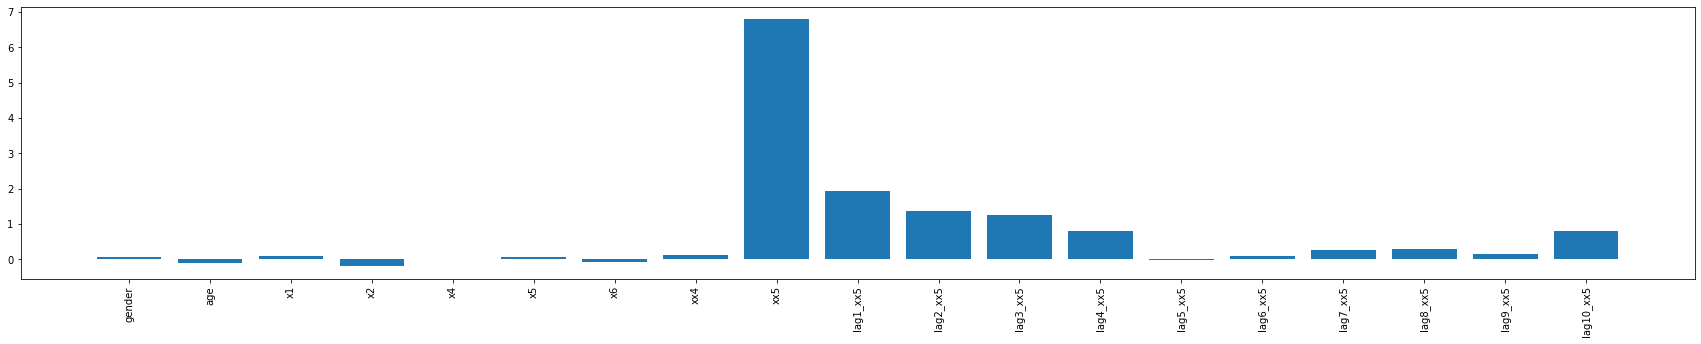

In [35]:
plt.figure(figsize=(30,5))
plt.bar(x=features, height=model.coef_)
# plt.yscale('log')
_ = plt.xticks(rotation=90)

In [92]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model,X_val, y_val['y_mean_MAP'],n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=[features[i] for i in sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [93]:
result = permutation_importance(model,X_train, y_train['y_mean_MAP'],n_jobs=-1)

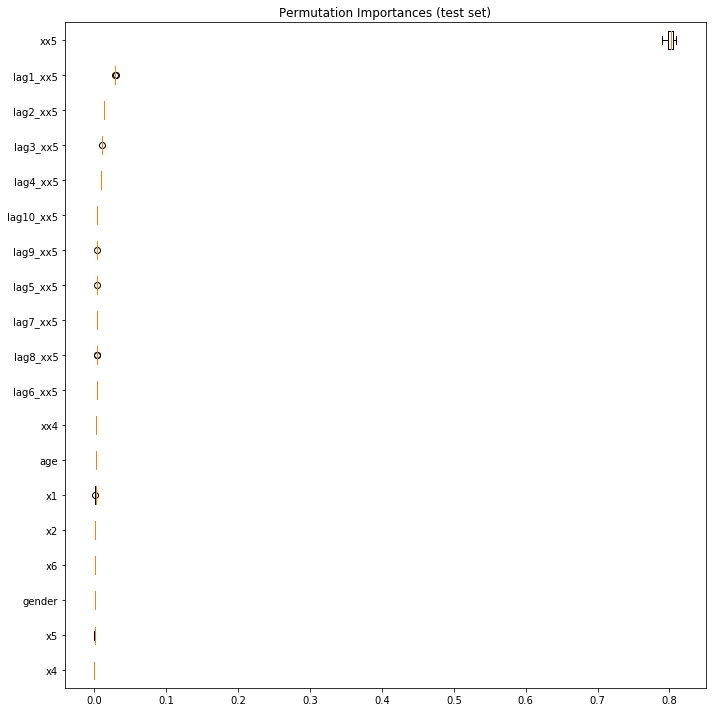

In [94]:
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=[features[i] for i in sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

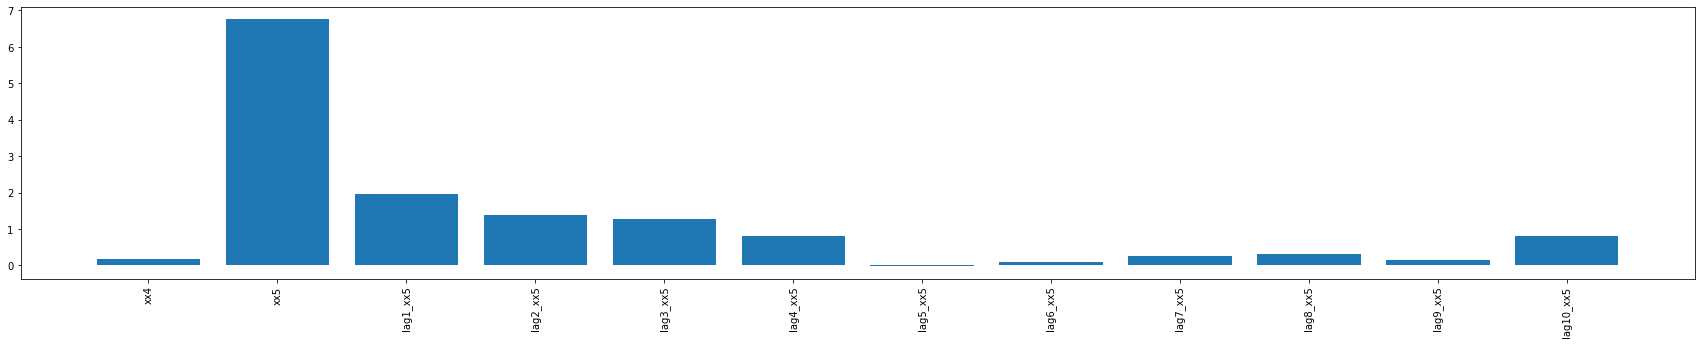

In [71]:
_ = plt.boxplot(y_train['y_mean_MAP'])

np.percentile(y_train['y_mean_MAP'], 1)

target = y_train['y_mean_MAP'].copy()

perc_95 = np.percentile(target, 95)

perc_95

In [81]:

target = target.apply(lambda x: 1 if x>=perc_95 else 0)

Counter(target)

In [102]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

# model, X_train, y_train['y_mean_MAP'], X_val, y_val['y_mean_MAP'],\
#                                               X_test, y_test['y_mean_MAP']

target.shape

model.fit(X_train, target)

from sklearn.metrics import classification_report

Counter(target)

test_val = y_val['y_mean_MAP'].apply(lambda x: 1 if x>=perc_95 else 0)

print(classification_report(target, model.predict(X_train)))

print(classification_report(test_val, model.predict(X_val)))

In [105]:
train_preds = model.predict(X_train)

In [106]:
val_preds = model.predict(X_val)

In [108]:
X_train = np.concatenate([X_train,train_preds.reshape(-1,1)],axis=1)

X_val = np.concatenate([X_val,val_preds.reshape(-1,1)],axis=1)

NameError: name 'X' is not defined

> test model

In [163]:
from sklearn.cluster import KMeans

ImportError: cannot import name 'lobpcg'

In [ ]:
kmeans = KM

In [456]:
train_score, test_score = get_cross_validation(model, X_train, y_train['y_mean_MAP'], X_val,
                                               y_val['y_mean_MAP'], X_test, y_test['y_mean_MAP']
                         , mode='test',
                        use_full=False)
print(f"train_score/test_score = {train_score}/{test_score}")

train_score/test_score = 0.8869718473512289/0.8327053009782198


> Use train + val data for training

In [457]:
train_score, test_score = get_cross_validation(model, X_train, y_train['y_mean_MAP']
                                               , X_val, y_val['y_mean_MAP'], 
                                               X_test, y_test['y_mean_MAP']
                         , mode='test',
                        use_full=True)
print(f"train_score/test_score = {train_score}/{test_score}")

train_score/test_score = 0.8887744847336537/0.832619877696266


<BarContainer object of 11 artists>

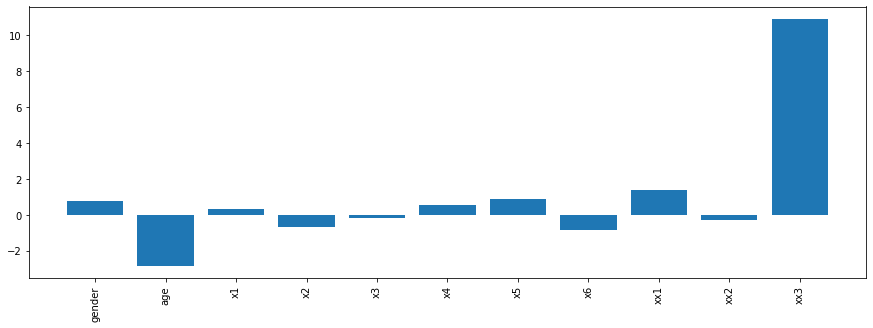

In [629]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.bar(features , model.coef_)

## for HR

In [36]:
features = [ 'gender', 'age', 'x1', 'x2', 'x4', 'x5', 'x6',
       'xx1', 'xx2', 'xx3', 'xx4', 'xx5', 'y_mean_MAP', 'y_mean_HR', 'lag1_xx1', 'lag2_xx1', 'lag3_xx1',
       'lag4_xx1', 'lag5_xx1', 'lag6_xx1', 'lag7_xx1', 'lag8_xx1', 'lag9_xx1',
       'lag10_xx1', 'lag1_xx2', 'lag2_xx2', 'lag3_xx2', 'lag4_xx2', 'lag5_xx2',
       'lag6_xx2', 'lag7_xx2', 'lag8_xx2', 'lag9_xx2', 'lag10_xx2', 'lag1_xx3',
       'lag2_xx3', 'lag3_xx3', 'lag4_xx3', 'lag5_xx3', 'lag6_xx3', 'lag7_xx3',
       'lag8_xx3', 'lag9_xx3', 'lag10_xx3', 'lag1_xx4', 'lag2_xx4', 'lag3_xx4',
       'lag4_xx4', 'lag5_xx4', 'lag6_xx4', 'lag7_xx4', 'lag8_xx4', 'lag9_xx4',
       'lag10_xx4', 'lag1_xx5', 'lag2_xx5', 'lag3_xx5', 'lag4_xx5', 'lag5_xx5',
       'lag6_xx5', 'lag7_xx5', 'lag8_xx5', 'lag9_xx5', 'lag10_xx5']

targets = ['y_mean_MAP', 'y_mean_HR']

features = [i for i in features if i not in targets]  # additional check

train, val, test = train_val_test(df, splits=[0.7,0.3,0.0],seed=42)

X_train, y_train, X_val, y_val, X_test, y_test = get_arrays(train, val, test, features, targets)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

> Validate model

In [37]:
train_score, val_score = get_cross_validation(model, X_train, y_train['y_mean_HR'], X_val, y_val['y_mean_HR'],
                                              X_test, y_test['y_mean_HR']
                         , mode='val',
                        use_full=True)
print(train_score, val_score)

0.9500942690566504 0.9324143945600095


<BarContainer object of 62 artists>

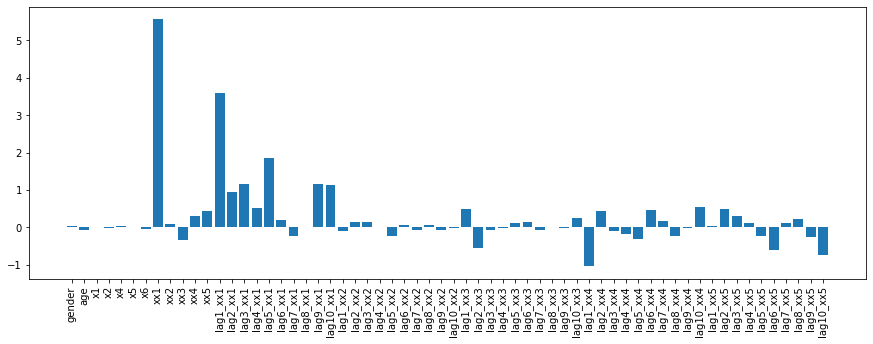

In [38]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.bar(features , model.coef_)

> test model

In [425]:
train_score, test_score = get_cross_validation(model, X_train, y_train['y_mean_HR'], X_val,
                                               y_val['y_mean_HR'], X_test, y_test['y_mean_HR']
                         , mode='test',
                        use_full=False)
print(f"train_score/test_score = {train_score}/{test_score}")

train_score/test_score = 0.9225858004511253/0.9323528735098146


> Use train + val data for training

In [426]:
train_score, test_score = get_cross_validation(model, X_train, y_train['y_mean_HR']
                                               , X_val, y_val['y_mean_HR'], 
                                               X_test, y_test['y_mean_HR']
                         , mode='test',
                        use_full=True)
print(f"train_score/test_score = {train_score}/{test_score}")

train_score/test_score = 0.9233389059446697/0.9323528050826447


<BarContainer object of 18 artists>

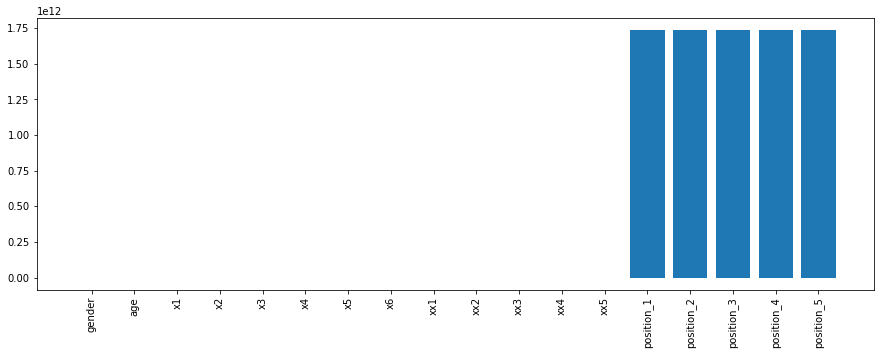

In [427]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.bar(features , model.coef_)

In [309]:
(0.942 + 0.8633)/2

0.90265

In [522]:
from tensorly.regression im

     |████████████████████████████████| 71kB 2.6MB/s eta 0:00:01
     |████████████████████████████████| 163kB 6.9MB/s eta 0:00:01
  Created wheel for tensorly: filename=tensorly-0.4.5-cp36-none-any.whl size=100154 sha256=5951078c5cac6485677d611bd5eac3f763b8a419d09d7f564545b182703eb5ac
  Stored in directory: /Users/nithish/Library/Caches/pip/wheels/44/ae/02/8d00229a4fd0af192b48d24da903f9975c7ac10e706685fc39
Successfully built tensorly


In [ ]:
# gp = df.groupby(['patient_id', 'key'],as_index=False)

# df_with_corr = []
# for key,group in gp:
#     arr1 = group.iloc[-1].values
#     arr_ = np.triu(group[['xx1', 'xx2', 'xx3', 'xx4', 'xx5']].corr()).ravel()
#     arr_ = arr_[[1,2,3,4,7,8,9,13,14,19]]
#     com = np.concatenate([arr1, arr_])
#     df_with_corr.append(com)

# with open('./data/df_with_corr.pickle','wb') as f:
#     pickle.dump(df_with_corr, f)

    
# # with open('./data/df_with_corr.pickle','rb') as f:
# #     df_with_corr = pickle.load(f)

# df_with_corr = pd.DataFrame(df_with_corr)